# Spray Glider - Hovmoller Analysis 

**Purpose**: Code for computing hovmoller diagrams for the Spray glider data  

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline


Import python libraries


In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import sys
import matplotlib 
from geopy.distance import geodesic
import cftime
import matplotlib.dates as mdates


Set path to access python functions


In [3]:
sys.path.append("../tools/")


Import my functions


In [4]:
import cartopy_figs as cart
import stats as stats

Set data analysis parameters

In [5]:
years_d      = ['2021', '2022', '2023']    # Years to analyze 
depth_lim = 200       # Lower bound of depth 

Load spray glider and intermediate data products (**NOTE**:  The intermediate data have the same profile coordinate as the spray glider data and have the same mask as the longitude and latitude from the spray glider data)

In [6]:
# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"

#--- Spray Glider Data ---# 
filename_sg = PATH + "/data/spray_gliders/CUGN_line_80.nc"
nc = Dataset(filename_sg, 'r')

# Extract data variables
profile = nc.variables['profile'][:]
depth   = nc.variables['depth'][:]

lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
lon_uv = nc.variables['lon_uv'][:]
lat_uv = nc.variables['lat_uv'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)
time_uv =  num2date(nc.variables['time_uv'][:], nc.variables['time_uv'].units)

temperature = nc.variables['temperature'][:]
salinity = nc.variables['salinity'][:]
chla = nc.variables['chlorophyll_a'][:]
doxy = nc.variables['doxy'][:]
u = nc.variables['u'][:]
v = nc.variables['v'][:]

#--- Intermediate Data ---# 
filename_int = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data.nc"
nc = Dataset(filename_int, 'r')

# Extract data variables
dist = nc.variables['DIST'][:]
dist_uv   = nc.variables['DIST_uv'][:]
water_depth = nc.variables['WATER_DEPTH'][:]
water_depth_uv   = nc.variables['WATER_DEPTH_uv'][:]

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Now grab temperature data from multiple years and at a single depth

In [7]:
# Grab temperature, salinity, horizontal velocities from a given depth 
#--- Single Depth ---#
depth_bin = depth[0]
temperature_dp = temperature[depth == depth_bin,:].T.squeeze()
#--- Depth averaged ---#
#depth_bin = depth[-2]
#temperature_dp = np.ma.mean(temperature[(depth >= depth[0]) & (depth <= depth_bin),:].T,axis=1)

# Grab indices of masked elements 
time_mask = np.array(np.where(time.mask))
lon_mask  = np.array(np.where(lon.mask))
lat_mask  = np.array(np.where(lat.mask))

# Check if the masked elements in time, lon, and lat 
if (time_mask == lon_mask).all() and (time_mask == lat_mask).all() and (lon_mask == lat_mask).all():

    # Combine masks from time and temperature 
    temp_mask = np.logical_or(temperature_dp.mask,time.mask)

    # Mask temperature, time, lon, and lat on the new mask 
    temp_m = np.ma.masked_where(temp_mask,temperature_dp)
    time_m = np.ma.masked_where(temp_mask,time)
    lon_m  = np.ma.masked_where(temp_mask,lon)
    lat_m  = np.ma.masked_where(temp_mask,lat)
    dist_m = np.ma.masked_where(temp_mask,dist)
    water_depth_m = np.ma.masked_where(temp_mask,water_depth)

    # Removed Masked values 
    temp_m_cn = temp_m.compressed()
    time_m_cn = time_m.compressed()
    lon_m_cn  = lon_m.compressed()
    lat_m_cn  = lat_m.compressed()
    dist_m_cn   = dist_m.compressed()
    water_depth_m_cn = water_depth_m.compressed()

    # Grab the years from the cleaned time array 
    years  = np.array([y.year for y in time_m_cn])

    # Initialize year array 
    temp_t = []
    time_t = []
    lon_t = []
    lat_t = []
    dist_t = []
    water_depth_t = []

    #--- Multi-Year Analysis ---# 
    # Loop through years 
    for iyear in range(0,len(years_d)):

        # Find indices for ith year
        year_idx = years == int(years_d[iyear]) 

        # Obtain time steps from ith year
        temp_t.extend(temp_m_cn[year_idx])
        time_t.extend(time_m_cn[year_idx])
        lon_t.extend(lon_m_cn[year_idx])
        lat_t.extend(lat_m_cn[year_idx])
        dist_t.extend(dist_m_cn[year_idx])
        water_depth_t.extend(water_depth_m_cn[year_idx])

    #--- Single Year Analysis ---# 
    # Grab time steps from a single year of analysis
    # year_idx    = years == int(year) 
    # time_idx    = year_idx
    # temp_t   = temp_m_cn[time_idx]
    # time_t   = time_m_cn[time_idx]
    # lon_t    = lon_m_cn[time_idx]
    # lat_t    = lat_m_cn[time_idx]

Compute the distance from the shore relative to Point Conception 

In [8]:
point_pc = (34.4488552,-120.457673)
point_sb = (34.23,-121.3)
distance_sb = geodesic(point_sb, point_pc).kilometers

Convert cftime.DatetimeGregorian to Python datetime objects

In [9]:
time_dt = [datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_t]

Generate sparse Hovmoller plot 

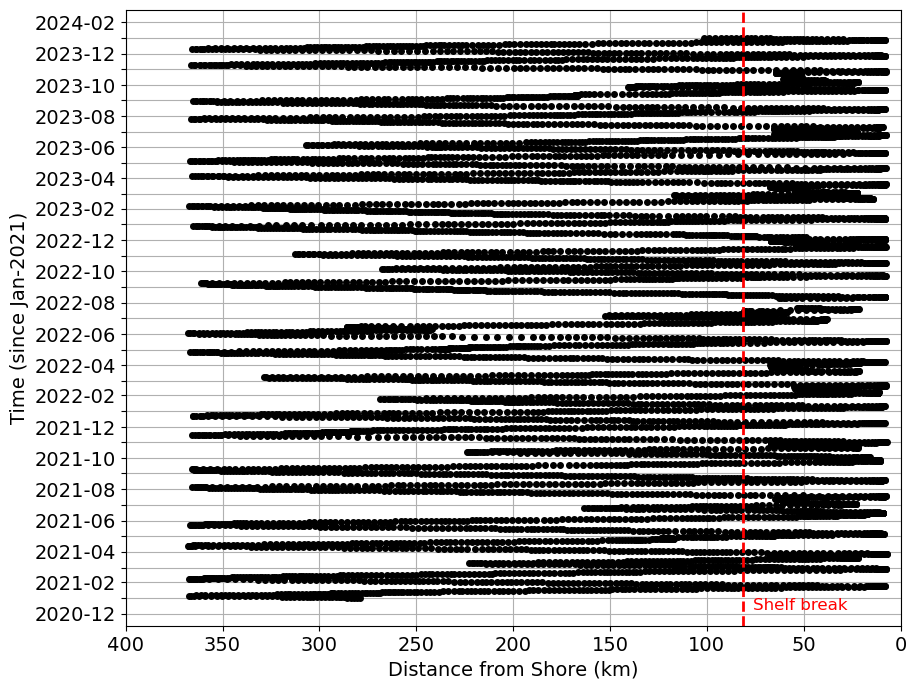

In [10]:
# Set plotting parameters
fontsize = 14
plt.rcParams.update({'font.size': fontsize})  # Change 14 to any desired size
plt.rcParams['text.usetex'] = False

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot trajectory through space time 
axes.plot(dist_t,time_dt,'ko',markersize=4)

# Plot the distance of the shelf break from the shore
plt.axvline(x=distance_sb, color='r', linestyle='--', linewidth=2, label='Vertical Line')

# Set axis attributes
axes.set_xlabel(r"Distance from Shore (km)")
axes.set_ylabel(r"Time (since Jan-" + years_d[0] + ")")
axes.set_xlim(0, 400)
axes.grid()

# Add label text near the vertical line
plt.text(distance_sb-5,time_dt[0], r'Shelf break', color='r', fontsize=12, ha='left',va='top',rotation=0)

# Set time axis tickmarks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

# Get the current tick labels
ticks = plt.gca().get_yticklabels()

# Hide every other tick label (e.g., hide even indexed ones)
for i, tick in enumerate(ticks):
    if i % 2 != 0:  # Hide every other tick (i.e., odd indexed ticks)
        tick.set_visible(False)

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis()

# Display figure
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/space_time_traj_' + years_d[0] + '_to_' + years_d[-1], bbox_inches = 'tight', dpi=300)

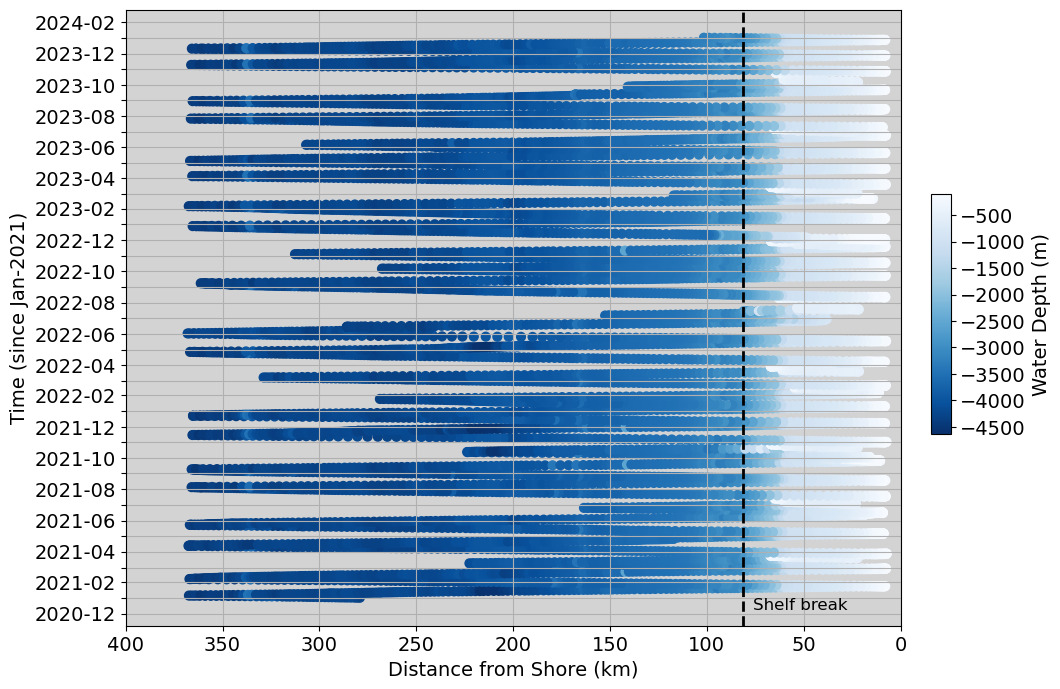

In [11]:
# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot trajectory through space time color coded by temperature
sc = axes.scatter(dist_t,time_dt,c=water_depth_t,cmap='Blues_r',s=40,marker='o') # ,edgecolor='k',linewidths=0.25

# Plot the distance of the shelf break from the shore
plt.axvline(x=distance_sb, color='k', linestyle='--', linewidth=2, label='Vertical Line')

# Set axis attributes
axes.set_xlabel(r"Distance from Shore (km)")
axes.set_ylabel(r"Time (since Jan-" + years_d[0] + ")")
axes.set_xlim(0, 400)
axes.grid()

# Add label text near the vertical line
plt.text(distance_sb-5,time_dt[0], r'Shelf break', color='k', fontsize=12, ha='left',va='top',rotation=0)

# Set time axis tickmarks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

# Get the current tick labels
ticks = plt.gca().get_yticklabels()

# Hide every other tick label (e.g., hide even indexed ones)
for i, tick in enumerate(ticks):
    if i % 2 != 0:  # Hide every other tick (i.e., odd indexed ticks)
        tick.set_visible(False)

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis()

# Create colormbar
cax = plt.axes([0.93, 0.35, 0.02, 0.3])
cart.set_cbar(
    sc,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=r"Water Depth (m)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set Colorbar limits 
#sc.set_clim(8, 10)

# Set the background color of the axes
axes.set_facecolor('lightgray')

# Display figure
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/space_time_traj_water_depth_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin), bbox_inches = 'tight', dpi=300)

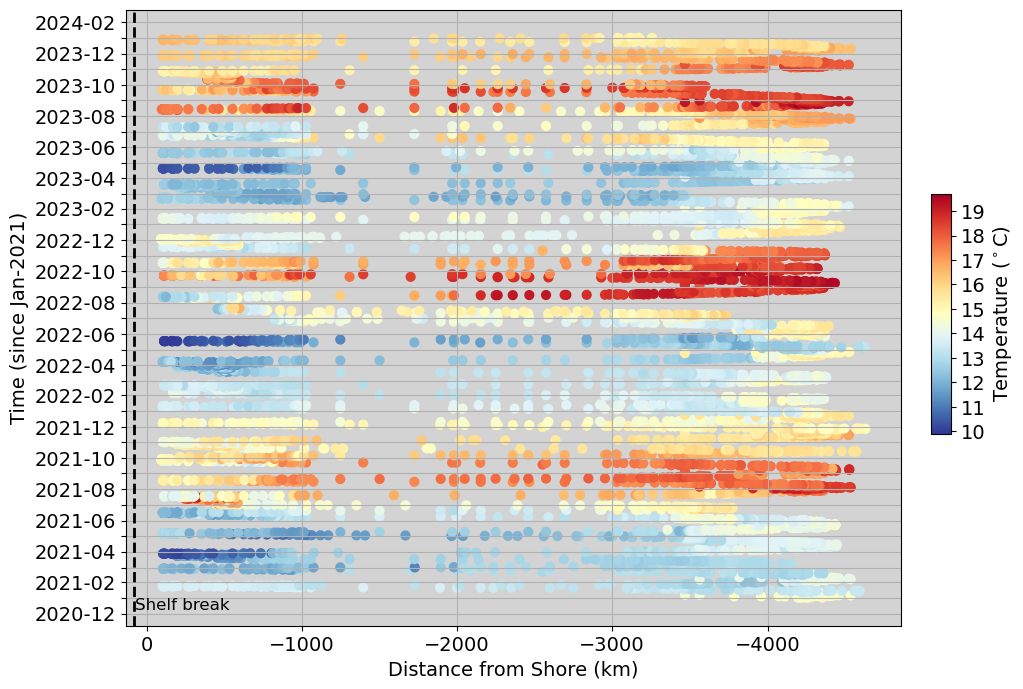

In [13]:
# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot trajectory through space time color coded by temperature
sc = axes.scatter(water_depth_t,time_dt,c=temp_t,cmap='RdYlBu_r',s=40,marker='o') # ,edgecolor='k',linewidths=0.25

# Plot the distance of the shelf break from the shore
plt.axvline(x=distance_sb, color='k', linestyle='--', linewidth=2, label='Vertical Line')

# Set axis attributes
axes.set_xlabel(r"Distance from Shore (km)")
axes.set_ylabel(r"Time (since Jan-" + years_d[0] + ")")
#axes.set_xlim(0, 400)
axes.grid()

# Add label text near the vertical line
plt.text(distance_sb-5,time_dt[0], r'Shelf break', color='k', fontsize=12, ha='left',va='top',rotation=0)

# Set time axis tickmarks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

# Get the current tick labels
ticks = plt.gca().get_yticklabels()

# Hide every other tick label (e.g., hide even indexed ones)
for i, tick in enumerate(ticks):
    if i % 2 != 0:  # Hide every other tick (i.e., odd indexed ticks)
        tick.set_visible(False)

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis()

# Create colormbar
cax = plt.axes([0.93, 0.35, 0.02, 0.3])
cart.set_cbar(
    sc,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=r"Temperature ($^\circ $C)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set Colorbar limits 
#sc.set_clim(8, 10)

# Set the background color of the axes
axes.set_facecolor('lightgray')

# Display figure
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/space_time_traj_temp_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin), bbox_inches = 'tight', dpi=300)

Compute temperature gradients

In [13]:
# Convert cftime.DatetimeGregorian to Python datetime and calculate days since 2016-01-01
reference_date = datetime(int(years_d[0]),1,1,0,0,0)
time_dt_ref = [ (datetime(t.year, t.month, t.day, t.hour, t.minute, t.second)- reference_date).total_seconds()/60 for t in time_t]

# Compute the change in temperature per distance traveled
delta_temp = np.gradient(temp_t,dist_t)

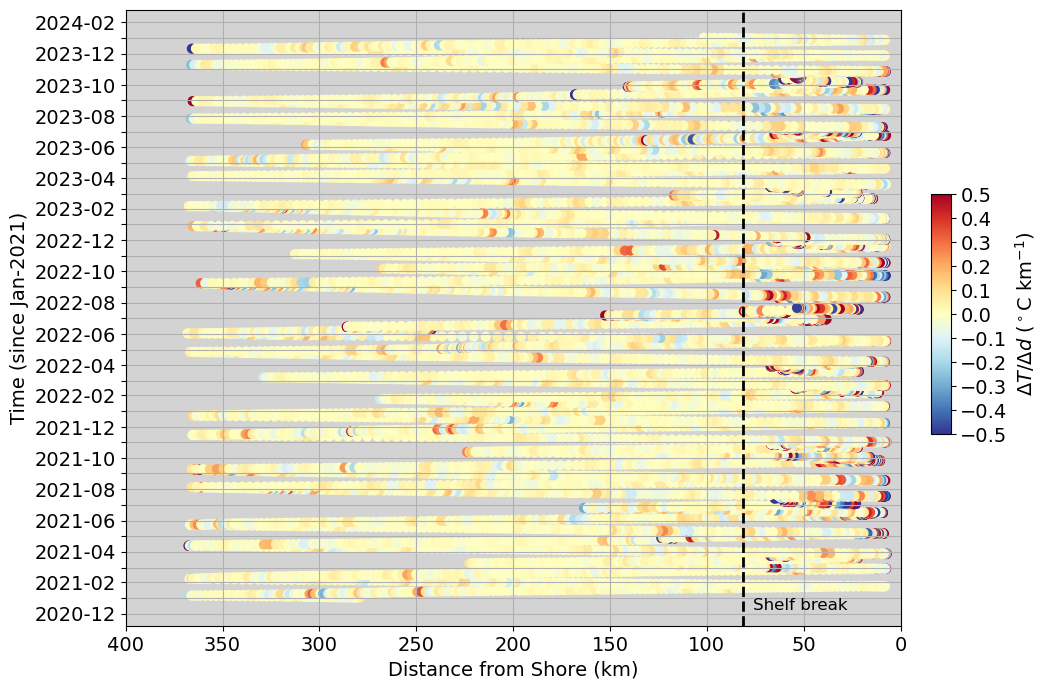

In [ ]:
# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot trajectory through space time color coded by temperature
sc = axes.scatter(dist_t,time_dt,c=delta_temp,cmap='RdYlBu_r',s=40,marker='o') # ,edgecolor='k',linewidths=0.25

# Plot the distance of the shelf break from the shore
plt.axvline(x=distance_sb, color='k', linestyle='--', linewidth=2, label='Vertical Line')

# Set axis attributes
axes.set_xlabel(r"Distance from Shore (km)")
axes.set_ylabel(r"Time (since Jan-" + years_d[0] + ")")
axes.set_xlim(0, 400)
axes.grid()

# Add label text near the vertical line
plt.text(distance_sb-5,time_dt[0], r'Shelf break', color='k', fontsize=12, ha='left',va='top',rotation=0)

# Set time axis tickmarks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

# Get the current tick labels
ticks = plt.gca().get_yticklabels()

# Hide every other tick label (e.g., hide even indexed ones)
for i, tick in enumerate(ticks):
    if i % 2 != 0:  # Hide every other tick (i.e., odd indexed ticks)
        tick.set_visible(False)

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis()

# Create colormbar
cax = plt.axes([0.93, 0.35, 0.02, 0.3])
cart.set_cbar(
    sc,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=r"$\Delta T / \Delta d$ ($^\circ $C km$^{-1}$)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set Colorbar limits 
sc.set_clim(-0.5, 0.5)

# Set the background color of the axes
axes.set_facecolor('lightgray')

# Display figure
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/space_time_traj_dTdD_' + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin), bbox_inches = 'tight', dpi=300)

Now grab total velocity data from multiple years and at a single depth

In [15]:
# Grab temperature, salinity, horizontal velocities from a given depth 
#--- Depth averaged ---#
depth_bin = depth[3]
u_dp = np.ma.mean(u[(depth >= depth[0]) & (depth <= depth_bin),:].T,axis=1)
v_dp = np.ma.mean(v[(depth >= depth[0]) & (depth <= depth_bin),:].T,axis=1)

# Grab indices of masked elements 
time_mask = np.array(np.where(time_uv.mask))
lon_mask  = np.array(np.where(lon_uv.mask))
lat_mask  = np.array(np.where(lat_uv.mask))

# Grab the mask of the u and v velocities 
u_dp_mask  = np.array(np.where(u_dp.mask))
v_dp_mask  = np.array(np.where(u_dp.mask))

# Check if the masked elements in time, lon, and lat 
if (time_mask == lon_mask).all() and (time_mask == lat_mask).all() and (lon_mask == lat_mask).all() and (u_dp_mask == v_dp_mask).all():

    # Combine masks from time and u 
    u_mask = np.logical_or(u_dp.mask,time_uv.mask)

    # Mask temperature, time, lon, and lat on the new mask 
    u_m = np.ma.masked_where(u_mask,u_dp)
    v_m = np.ma.masked_where(u_mask,v_dp)
    time_m = np.ma.masked_where(u_mask,time_uv)
    lon_m  = np.ma.masked_where(u_mask,lon_uv)
    lat_m  = np.ma.masked_where(u_mask,lat_uv)
    dist_m = np.ma.masked_where(u_mask,dist_uv)
    water_depth_m = np.ma.masked_where(u_mask,water_depth_uv)

    # Removed Masked values 
    u_m_cn = u_m.compressed()
    v_m_cn = v_m.compressed()
    time_m_cn = time_m.compressed()
    lon_m_cn  = lon_m.compressed()
    lat_m_cn  = lat_m.compressed()
    dist_m_cn   = dist_m.compressed()
    water_depth_m_cn = water_depth_m.compressed()

    # Grab the years from the cleaned time array 
    years  = np.array([y.year for y in time_m_cn])

    # Initialize year array 
    u_t = []
    v_t = []
    time_t = []
    lon_t = []
    lat_t = []
    dist_t = []
    water_depth_t = []

    #--- Multi-Year Analysis ---# 
    # Loop through years 
    for iyear in range(0,len(years_d)):

        # Find indices for ith year
        year_idx    = years == int(years_d[iyear]) 

        # Obtain time steps from ith year
        u_t.extend(u_m_cn[year_idx])
        v_t.extend(v_m_cn[year_idx])
        time_t.extend(time_m_cn[year_idx])
        lon_t.extend(lon_m_cn[year_idx])
        lat_t.extend(lat_m_cn[year_idx])
        dist_t.extend(dist_m_cn[year_idx])
        water_depth_t.extend(water_depth_m_cn[year_idx])

# Convert variables to numpy arrays
u_t = np.array(u_t)
v_t = np.array(v_t)
dist_t = np.array(dist_t)
water_depth_t = np.array(water_depth_t)


Convert cftime.DatetimeGregorian to Python datetime objects

In [16]:
time_dt = [datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_t]

Generate Hovmoller plot

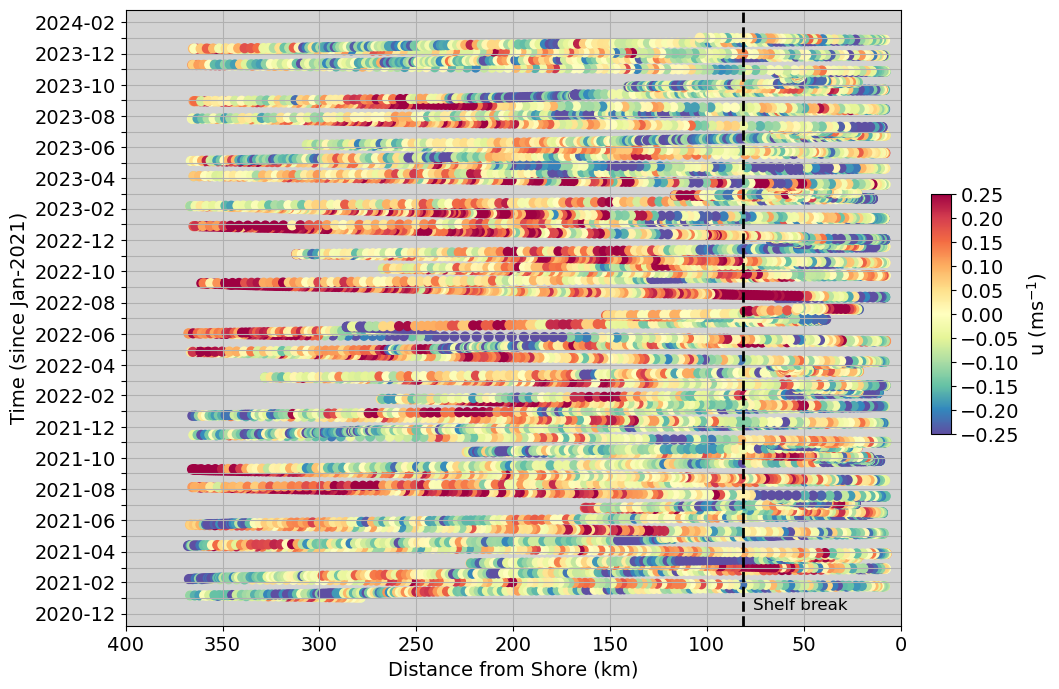

In [17]:
# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot trajectory through space time color coded by temperature
sc = axes.scatter(dist_t,time_dt,c=u_t,cmap='Spectral_r',s=40,marker='o') # ,edgecolor='k',linewidths=0.25

# Plot the distance of the shelf break from the shore
plt.axvline(x=distance_sb, color='k', linestyle='--', linewidth=2, label='Vertical Line')

# Set axis attributes
axes.set_xlabel(r"Distance from Shore (km)")
axes.set_ylabel(r"Time (since Jan-" + years_d[0] + ")")
axes.set_xlim(0, 400)
axes.grid()

# Add label text near the vertical line
plt.text(distance_sb-5,time_dt[0], r'Shelf break', color='k', fontsize=12, ha='left',va='top',rotation=0)

# Set time axis tickmarks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

# Get the current tick labels
ticks = plt.gca().get_yticklabels()

# Hide every other tick label (e.g., hide even indexed ones)
for i, tick in enumerate(ticks):
    if i % 2 != 0:  # Hide every other tick (i.e., odd indexed ticks)
        tick.set_visible(False)

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis()

# Create colormbar
cax = plt.axes([0.93, 0.35, 0.02, 0.3])
cart.set_cbar(
    sc,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=r"u (ms$^{-1}$)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set Colorbar limits 
sc.set_clim(-0.25, 0.25)

# Set the background color of the axes
axes.set_facecolor('lightgray')

# Display figure
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/space_time_traj_u_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin), bbox_inches = 'tight', dpi=300)

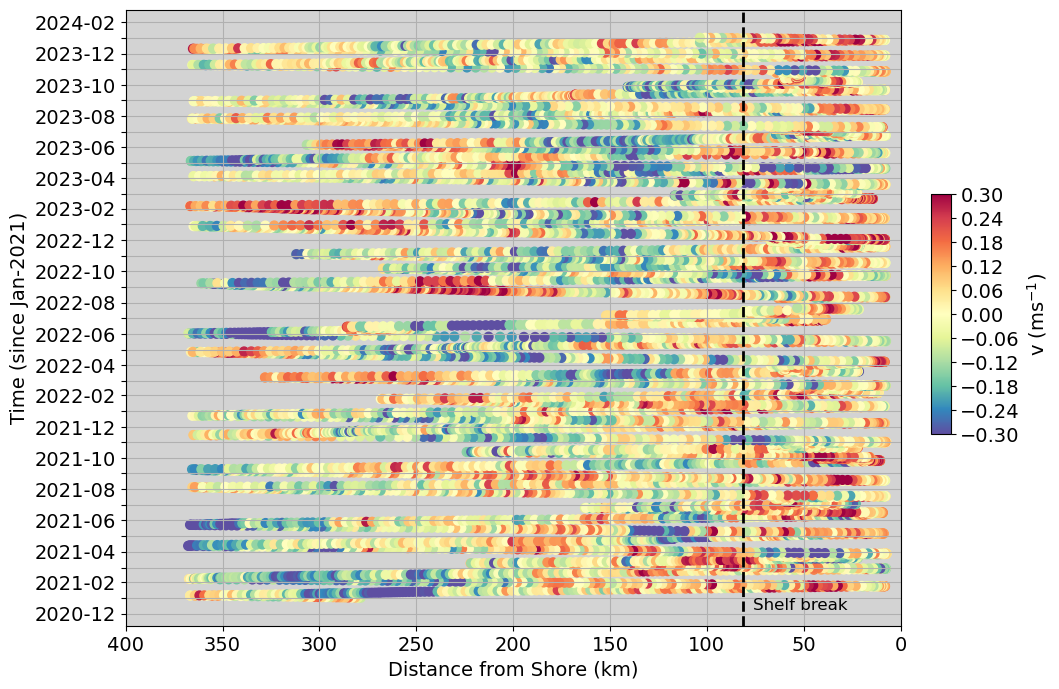

In [ ]:
# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot trajectory through space time color coded by temperature
sc = axes.scatter(dist_t,time_dt,c=v_t,cmap='Spectral_r',s=40,marker='o') # ,edgecolor='k',linewidths=0.25

# Plot the distance of the shelf break from the shore
plt.axvline(x=distance_sb, color='k', linestyle='--', linewidth=2, label='Vertical Line')

# Set axis attributes
axes.set_xlabel(r"Distance from Shore (km)")
axes.set_ylabel(r"Time (since Jan-" + years_d[0] + ")")
axes.set_xlim(0, 400)
axes.grid()

# Add label text near the vertical line
plt.text(distance_sb-5,time_dt[0], r'Shelf break', color='k', fontsize=12, ha='left',va='top',rotation=0)

# Set time axis tickmarks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

# Get the current tick labels
ticks = plt.gca().get_yticklabels()

# Hide every other tick label (e.g., hide even indexed ones)
for i, tick in enumerate(ticks):
    if i % 2 != 0:  # Hide every other tick (i.e., odd indexed ticks)
        tick.set_visible(False)

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis()

# Create colormbar
cax = plt.axes([0.93, 0.35, 0.02, 0.3])
cart.set_cbar(
    sc,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=r"v (ms$^{-1}$)",
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set Colorbar limits 
sc.set_clim(-0.3, 0.3)

# Set the background color of the axes
axes.set_facecolor('lightgray')

# Display figure
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/space_time_traj_v_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin), bbox_inches = 'tight', dpi=300)

Plot a histogram of water depth 

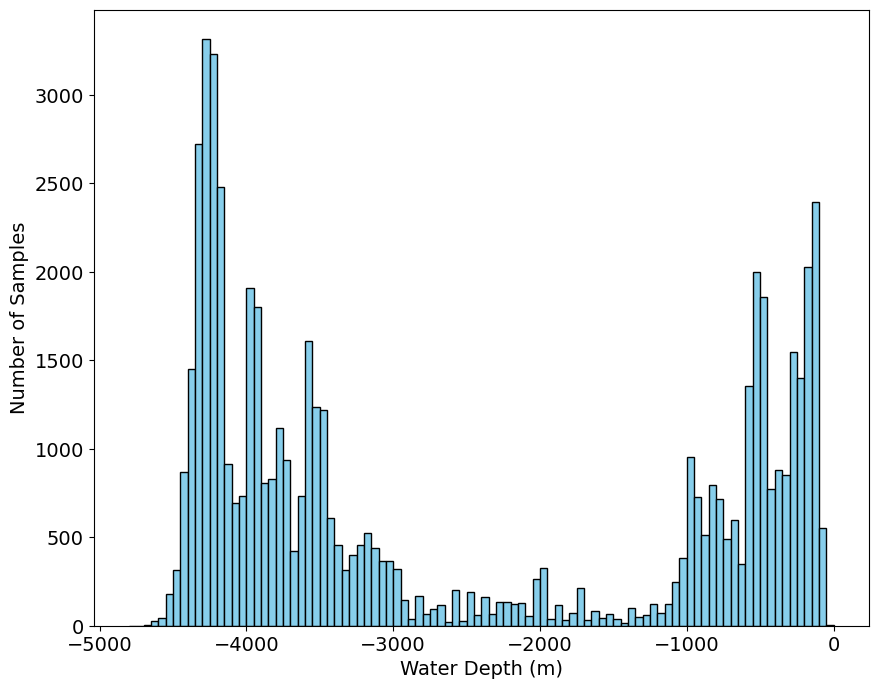

In [ ]:
# Set bin edges
step = 50
bin_edges = np.arange(-4800,0+step,step)

# Compute histogram 
counts_wd, pdf_wd = stats.compute_pdf_1D(water_depth,bin_edges)

# Calculate bin centers from edges
bin_width = bin_edges[1]-bin_edges[0]
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot histogram
plt.bar(bin_centers, counts_wd, width=bin_width, edgecolor='black', color='skyblue', align='center')

# Set figure attributes
plt.xlabel('Water Depth (m)')
plt.ylabel('Number of Samples')

# Show the plot
plt.show()

Compute the slope of the bathymetry 

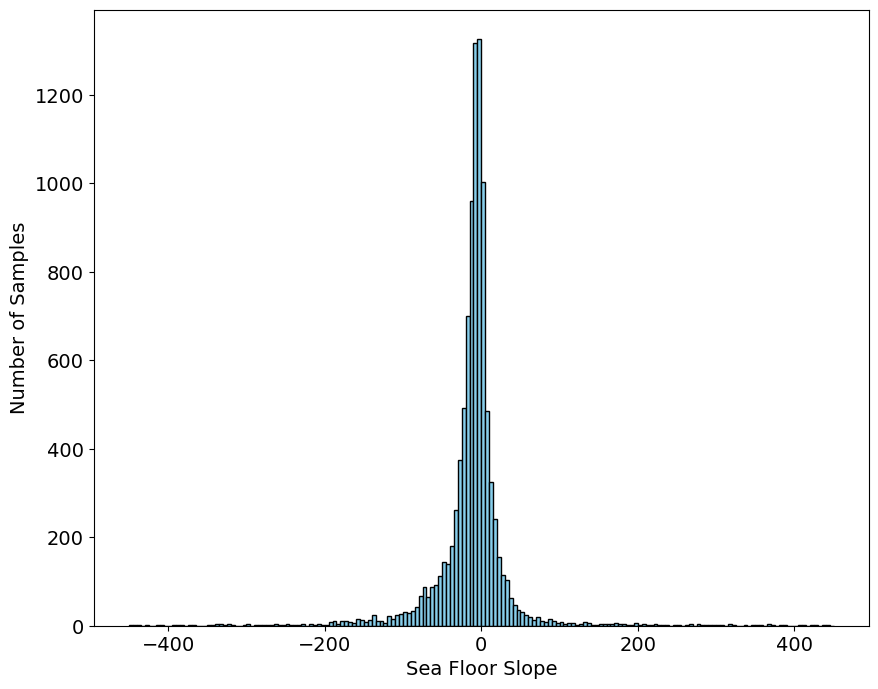

In [ ]:
# Compute the slope
delta_wd = np.gradient(water_depth_t,dist_t)

# Set bin edges
step = 5
bin_edges = np.arange(-450,450+step,step)

# Compute histogram 
counts_dwd, pdf_dwd = stats.compute_pdf_1D(delta_wd,bin_edges)

# Calculate bin centers from edges
bin_width = bin_edges[1]-bin_edges[0]
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot histogram
plt.bar(bin_centers, counts_dwd, width=bin_width, edgecolor='black', color='skyblue', align='center')

# Set figure attributes
plt.xlabel('Sea Floor Slope')
plt.ylabel('Number of Samples')

# Show the plot
plt.show()

Compute and plot the joint PDF of water depth and sea surface slope 

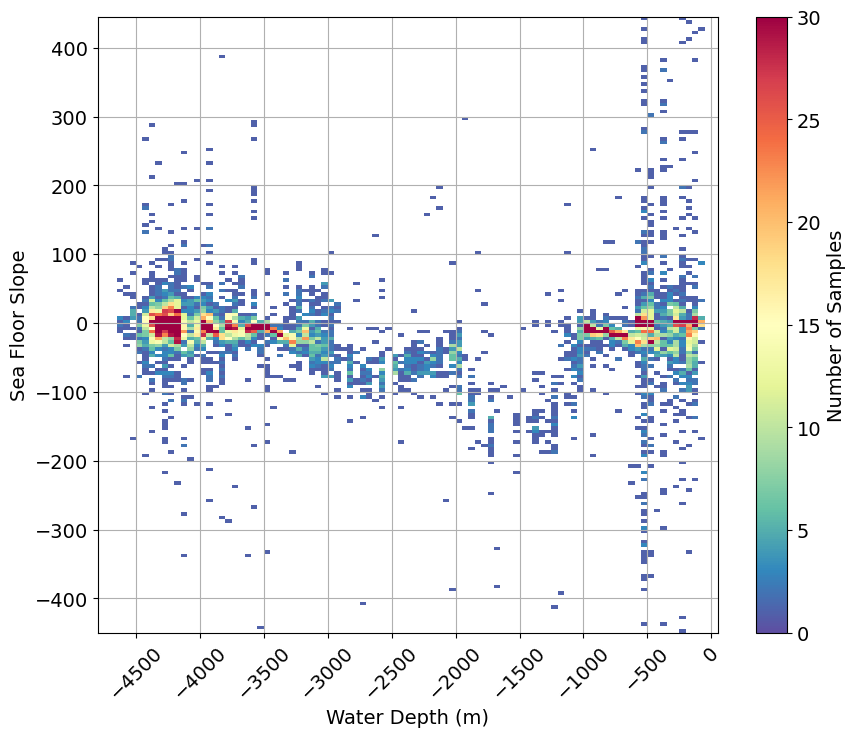

In [ ]:
# Set the grid for water depth and sea floor slope for joint PDF
wd = np.arange(-4800,0+100,50)
dwd = np.arange(-450,450,5)
WD, DWD = np.meshgrid(wd, dwd)

# Compute joint PDF 
counts, pdf, wd_center, dwd_center = stats.compute_pdf_2D(water_depth_t,delta_wd,WD,DWD)

# Mask zero counts (set them to NaN)
counts_masked = np.where(counts == 0, np.nan, counts)

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot pdf
plt.pcolormesh(wd_center, dwd_center, counts_masked.T, cmap="Spectral_r", shading="auto")

# Set figure attributes
plt.xlabel('Water Depth (m)')
plt.ylabel('Sea Floor Slope')
plt.xticks(np.arange(-4500,0+500,500),rotation=45)
plt.grid()
plt.colorbar(label="Number of Samples")
plt.clim(0,30)

# Show the plot
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/joint_pdf_depth_vs_slope_'  + years_d[0] + '_to_' + years_d[-1], bbox_inches = 'tight', dpi=300)

Compute probability density function on and off shore (seperated by the shelf break)

In [43]:
# Set the uv meshgrid 
step = 0.04
u = np.arange(-0.3,0.3+step,step)
v = np.arange(-0.3,0.3+step,step)
U, V = np.meshgrid(u, v)

# Find indices for off-shelf (water depths > 4000) and on-shelf (water depths < 300)
idx_off = np.array(water_depth_t <= -4000)
idx_on = np.array(water_depth_t >= -300)

# Obtain the off- and on- shelf velocities 
u_off = u_t[idx_off]
u_on = u_t[idx_on]
v_off = v_t[idx_off]
v_on = v_t[idx_on]

#--- Off-shelf ---# 
_, pdf_off, u_center, v_center = stats.compute_pdf_2D(u_off,v_off,U,V)

#--- On-shelf ---# 
_, pdf_on, u_center, v_center = stats.compute_pdf_2D(u_on,v_on,U,V)

#--- Full data set ---# 
_, pdf_full, u_center, v_center = stats.compute_pdf_2D(u_t,v_t,U,V)

# Mask zeros (set them to NaN)
pdf_off_masked = np.where(pdf_off == 0, np.nan, pdf_off)
pdf_on_masked = np.where(pdf_on == 0, np.nan, pdf_on)
pdf_full_masked = np.where(pdf_full == 0, np.nan, pdf_full)

Plot joint PDFs 

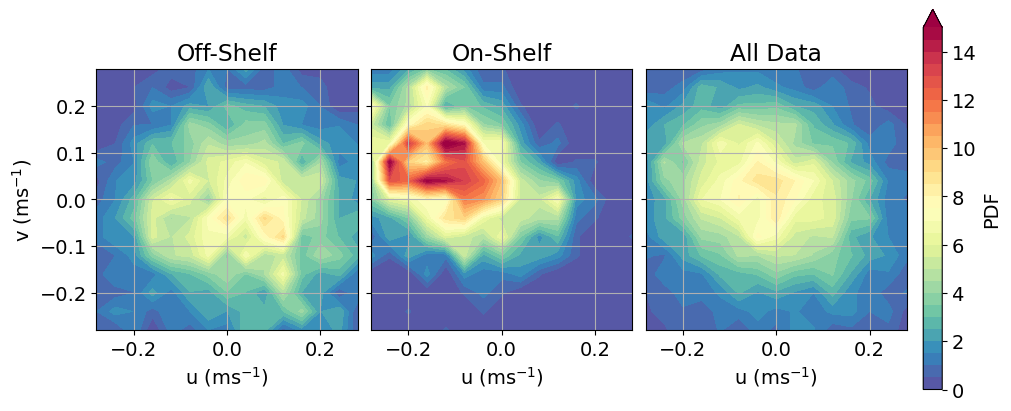

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure
fig, axes = plt.subplots(1,3,constrained_layout=True)

# Set the figure size using set_size_inches
fig.set_size_inches(10, 4) 

# Define a common colormap range for all subplots
vmin, vmax = 0, 15
step = 0.5
levels = np.arange(vmin, vmax+step,step)

#--- Off-shelf ---# 

# Plot pdf
#plt.pcolormesh(u_center, v_center, pdf_on.T, cmap="Spectral_r", shading="auto")
ct = axes[0].contourf(u_center, v_center, pdf_off.T, levels=levels, cmap="Spectral_r", extend='max')

# Set figure attributes
axes[0].set_xlabel(r'u (ms$^{-1}$)')
axes[0].set_ylabel(r'v (ms$^{-1}$)')
axes[0].grid()
axes[0].set_title('Off-Shelf')
axes[0].set_aspect('equal')

#--- On-shelf ---# 

# Plot pdf
#plt.pcolormesh(u_center, v_center, pdf_on.T, cmap="Spectral_r", shading="auto")
axes[1].contourf(u_center, v_center, pdf_on.T, levels=levels, cmap="Spectral_r", extend='max')

# Set figure attributes
axes[1].set_xlabel(r'u (ms$^{-1}$)')
axes[1].tick_params(axis='y', labelleft=False)
axes[1].grid()
axes[1].set_title('On-Shelf')
axes[1].set_aspect('equal')

#--- Full ---# 

# Plot pdf
#plt.pcolormesh(u_center, v_center, pdf_on.T, cmap="Spectral_r", shading="auto")
axes[2].contourf(u_center, v_center, pdf_full.T, levels=levels, cmap="Spectral_r", extend='max')

# Set figure attributes
axes[2].set_xlabel(r'u (ms$^{-1}$)')
axes[2].tick_params(axis='y', labelleft=False)
axes[2].grid()
axes[2].set_title('All Data')
axes[2].set_aspect('equal')

# Add a single colorbar using one of the contour sets
cbar = fig.colorbar(ct, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label("PDF")

# Show the plot
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/joint_pdf_u_vs_v_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin), bbox_inches = 'tight', dpi=300)